# preliminaries

In [1]:
import numpy as np                  # we are using numpy
from lqcd.jackknife import *        # some module we wrote to perform single elimination jackknife
from lqcd.py_fit import *           # some module we wrote to fit our data to a model

import matplotlib.pyplot as plt     # so we can make pretty plots
%matplotlib inline                  
# and display them in the jupyter notebook

# Nucleon Correlator

the nucleon correlator:

$C(t) = \sum_{\vec{x}} < \Omega | O(\vec{x},t)O^\dagger(\vec{0},0) >$

from a single interpolating operator:

$O = \epsilon_{abc} u_a C\gamma_5 d_B u_c$

has quantum numbers $J^P = 1/2^+$ [verifiable analytically]


In [2]:
# let's get the configuration numbers we will be using to estimate the Feynmann Path Integral
def get_conf(fileloc):
    c=open(fileloc,'r')
    conf_list=[]
    for line in c:
        konf=int(line)
        conf_list.append(konf)
    print("N_konf:",len(conf_list))
    return conf_list

the gauge ensemble: $32^3 \times 64$ with $193$ gauge field configurations  
limit our analysis to first $25$ timeslices

In [4]:
Nt=25
conf_list=get_conf("./cnfg.all")
Nkonf=len(conf_list)

N_konf: 193


# Section I :: jackknife

raw nucleon correlation functions $C(t)$

In [6]:
def read_nucleon_C(conf_list,Nt):
    Nkonf=len(conf_list)
    C=np.zeros((Nkonf,Nt),dtype=np.complex)
    for ikonf in range(Nkonf):
        konf=conf_list[ikonf]
        with open("./data/nucleon_C_"+str(konf)+".corr",'r') as f:
            for line in f:
                aa=line.split()
                t=int(aa[0])
                re=float(aa[1])
                im=float(aa[2])
                C[ikonf,t]=re+1j*im
                
    return C

In [7]:
C=read_nucleon_C(conf_list,Nt)

average of raw corrleation functions  
avg_C$(t) = \frac{1}{N_{konf}} \sum_{i=1}^{N_{konf}} C_i(t)$

In [8]:
avg_C=jack_average_vector(C)

jackknife resampling and uncertainties  
jack_$C_J(t) = \sum_{i=1}^{N_{konf}} (1-\delta_{i,J}) \frac{C_i(t)}{N_{konf}-1}$

In [9]:
jack_C=jack_resample_vector(C)

In [10]:
sig_C=jack_sigma_vector(jack_C)

plot of correlation function with uncertainties  
note: signal is in real part, imaginary is only noise

[]

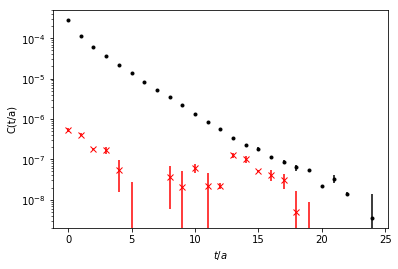

In [11]:
for t in range(Nt):
    plt.errorbar(t,avg_C[t].real,yerr=sig_C[t].real,color='black',ls='-',marker='.')
    plt.errorbar(t,-avg_C[t].imag,yerr=sig_C[t].imag,color='red',ls='-',marker='x')

plt.xlabel("$t/a$")
plt.ylabel("C(t/a)")
plt.semilogy()


In [12]:
def fit_correlator(avg_C,jack_C,tmin,tmax,minit,fit_type='1exp'):
    jac=jack_C[:,tmin:tmax+1].real
    ev=avg_C[tmin:tmax+1].real
    pinit=np.asarray([ev[0],minit])
    N=tmax-tmin+1

    chi2, res, succ = fit_eigenvalue(fit_type,Nkonf,tmin,tmax,pinit,jac,ev,ev)
    cv_A = res.x[0]
    cv_E = res.x[1]

    jack_E = np.zeros(Nkonf)
    jack_A = np.zeros(Nkonf)
    for konf in range(Nkonf):
        evj=jack_C[konf,tmin:tmax+1].real
        chi2, res, succ = fit_eigenvalue(fit_type,Nkonf,tmin,tmax,pinit,jac,ev,evj)
        jack_A[konf]=res.x[0]
        jack_E[konf]=res.x[1]
    return cv_A,jack_A,cv_E,jack_E

In [24]:
tmin=7
tmax=20
minit = 0.4
cvA,jackA,cvE,jackE = fit_correlator(avg_C,jack_C,tmin,tmax,minit)
sigE=jack_sigma_scalar(jackE)
sigA=jack_sigma_scalar(jackA)

In [25]:
def reconstruct_C(cvA,cvE,tmin,tmax):
    tt=np.linspace(tmin,tmax+1,400)
    cvC=np.zeros(400)
    for it in range(400):
        t=tt[it]-tmin
        cvC[it] = f_one_exp(t, [cvA,cvE])
    return tt,cvC

In [26]:
tt,cvC=reconstruct_C(cvA,cvE,tmin,tmax)

[]

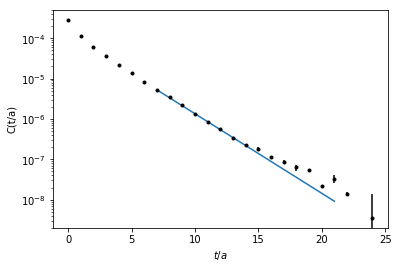

In [27]:
for t in range(Nt):
    plt.errorbar(t,avg_C[t].real,yerr=sig_C[t].real,color='black',ls='-',marker='.')

plt.plot(tt,cvC)

plt.xlabel("$t/a$")
plt.ylabel("C(t/a)")
plt.semilogy()

# effective mass

In [28]:
def meff(C):
    m_eff=np.zeros(C.shape[0]-1)
    for t in range(len(C)-1):
        m_eff[t]=np.log(C[t].real/C[t+1].real)
    return m_eff

In [29]:
Meff_avg=meff(avg_C)

/home/leskovec/.conda/envs/lattice3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [30]:
Meff_j = np.zeros((Nkonf,Nt-1))
for konf in range(Nkonf):
    Meff_j[konf,:]=meff(jack_C[konf,:].real)
Meff_sig=jack_sigma_vector(Meff_j)

/home/leskovec/.conda/envs/lattice3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


(0, 25)

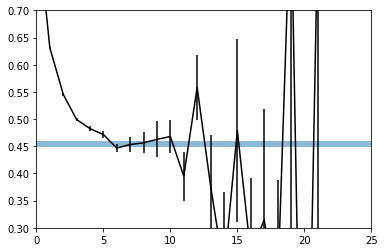

In [31]:
plt.errorbar([i for i in range(Nt-1)],Meff_avg.real,yerr=Meff_sig.real,color='black',ls='-')
plt.fill_between([0,Nt],cvE-sigE,cvE+sigE,alpha=0.5)
plt.ylim(0.3,0.7)
plt.xlim(0,25)

# to the physical scale

In [35]:
def set_scale(a):
    #using NIST data for hbar and c
    #hbar[eV] 6.582 119 514 x 10-16 eV s
    #speed of light [m/2] 299 792 458 m s-1
    #spacing must be in fermi
    hbarc=197.32697879518255
    scale=hbarc/a
    return scale

In [36]:
#lattice scale a=0.0907fm
ainv = set_scale(0.0907)

In [37]:
print("m: ",ainv*cvE,"+-",ainv*sigE)

m:  987.6614835938791 +- 13.306458015495972
